In [1]:
import pygame
import numpy as np
from time import sleep
from gymnasium import Env, spaces, register, make
import random
import os
import sys
import pandas as pd
from tqdm import tqdm, trange
import math
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.3, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
notebook_dir = os.getcwd()
images_dir = os.path.join(notebook_dir,'..','Report','images','mc_td')
os.makedirs(images_dir, exist_ok=True)

## 1. Create the Random Walk Environment
Below I created the environment by subclassing the `Env` class from gymnasium and tested out the result on a pygame simulation. The agent receives a reward of $1.0$ only when it lands on a terminal state, or else no reward.

In [3]:

class RandomWalkEnvironment(Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, config=None, render_mode=None):
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        assert config is None or isinstance(config, dict)
        self.P = {
            0: { # Terminal State
                0: [(1.0, 0, 1.0, True)],
                1: [(1.0, 0, 1.0, True)]
            },
            1: {
                0: [(0.5, 0, 0.0, True), (0.5, 2, 0.0, False)],
                1: [(0.5, 2, 0.0, False), (0.5, 0, 0.0, True)]
            },
            2: { 
                0: [(0.5, 1, 0.0, False), (0.5, 3, 0.0, False)],
                1: [(0.5, 3, 0.0, False), (0.5, 1, 0.0, False)]
            },
            3: { 
                0: [(0.5, 2, 0.0, False), (0.5, 4, 0.0, False)],
                1: [(0.5, 4, 0.0, False), (0.5, 2, 0.0, False)]
            },
            4: { 
                0: [(0.5, 3, 0.0, False), (0.5, 5, 0.0, False)],
                1: [(0.5, 5, 0.0, False), (0.5, 3, 0.0, False)]
            },
            5: { 
                0: [(0.5, 4, 0.0, False), (0.5, 6, 1.0, True)],
                1: [(0.5, 6, 1.0, True), (0.5, 4, 0.0, False)]
            },
            6: { # Terminal State
                0: [(1.0, 6, 0.0, True)],
                1: [(1.0, 6, 0.0, True)]
            },
            
        }
        self.size = 7  # The size of the 1D grid
        self.window_size = 512  # The size of the PyGame window

        # We have 3 observations, corresponding to each position in the 1-D grid
        self.observation_space = spaces.Discrete(self.size)

        # We have 2 actions, corresponding to "left" & "right"
        self.action_space = spaces.Discrete(2)

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode
        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

        # The probability of the slip
        # self.slip_prob = slip_prob
        
        self._START_STATE = 3
        self._TERMINAL_STATES = [0, 6]
        random.seed(config.get("seed", 21))
        self.seed = (config.get("seed", 21))

    def _get_obs(self):

        return {"agent": self._agent_location, "terminals": self._terminal_states}


    def _get_info(self):
        return {
            "distance": min(abs(self._agent_location - self._terminal_states[0]), abs(self._agent_location - self._terminal_states[0]))
        }

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._agent_location = self._START_STATE
        self._terminal_states = self._TERMINAL_STATES

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info


    def step(self, action):

        prev_location = self._agent_location
        transitions = self.P[prev_location][action]
        probabilities, next_states, rewards, terminals = zip(*transitions)

        # Randomly select a transition based on the probabilities
        index = random.choices(range(len(probabilities)), weights=probabilities, k=1)[0]
        self._agent_location, reward, terminated = next_states[index], rewards[index], terminals[index]

        truncated = False
        observation = self._get_obs()
        info = self._get_info()

        info["log"] = {"current_state": prev_location,
                       "action":action,
                        "next_state": self._agent_location,
                        "reward": reward}

        if self.render_mode == "human":
            self._render_frame()

        # Return the required 5-tuple
        return observation, reward, terminated, truncated, info


    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):


        # The size of a single grid square in pixels
        pix_square_size = (
            self.window_size / self.size
        )

        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_size, pix_square_size)
            )

        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, pix_square_size))
        canvas.fill((255, 255, 255))


        # Draw both the terminal states
        pygame.draw.rect(
            canvas,
            '#EF5350',
            pygame.Rect(
                pix_square_size * np.array([self._terminal_states[0], 0]),
                (pix_square_size, pix_square_size),
            ),
        )
        
        pygame.draw.rect(
            canvas,
            '#EF5350',
            pygame.Rect(
                pix_square_size * np.array([self._terminal_states[1], 0]),
                (pix_square_size, pix_square_size),
            ),
        )

        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            '#3F51B5',
            (np.array([self._agent_location, 0]) + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

# Register the environment
register(
    id="RandomWalk-v0",
    entry_point=RandomWalkEnvironment,
    max_episode_steps=1000,
    reward_threshold=1.0,
)

In [4]:
# Create and use the environment
CONFIG = {
    "seed": 21, # following an internet meme
    'max_episodes': 5,
    'discount_factor': 0.99,
    'policy_name': 'go_left'
    }
environment = make('RandomWalk-v0', config=CONFIG, render_mode="human")
observation, info = environment.reset(seed=CONFIG['seed'])
episode = 1
while episode <= CONFIG['max_episodes']:
    action = environment.action_space.sample()  # this is where you would insert your policy
    observation, reward, terminated, truncated, info = environment.step(action)

    print(info["log"])

    if terminated:
        print("Terminated", "\n\n")
        episode += 1

    if terminated or truncated:
        observation, info = environment.reset(seed=CONFIG['seed'])
environment.close()

c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserW

{'current_state': 3, 'action': 1, 'next_state': 4, 'reward': 0.0}
{'current_state': 4, 'action': 0, 'next_state': 5, 'reward': 0.0}
{'current_state': 5, 'action': 0, 'next_state': 6, 'reward': 1.0}
Terminated 


{'current_state': 3, 'action': 1, 'next_state': 4, 'reward': 0.0}
{'current_state': 4, 'action': 1, 'next_state': 5, 'reward': 0.0}
{'current_state': 5, 'action': 1, 'next_state': 4, 'reward': 0.0}
{'current_state': 4, 'action': 1, 'next_state': 3, 'reward': 0.0}
{'current_state': 3, 'action': 1, 'next_state': 2, 'reward': 0.0}
{'current_state': 2, 'action': 0, 'next_state': 3, 'reward': 0.0}
{'current_state': 3, 'action': 1, 'next_state': 4, 'reward': 0.0}
{'current_state': 4, 'action': 0, 'next_state': 3, 'reward': 0.0}
{'current_state': 3, 'action': 0, 'next_state': 2, 'reward': 0.0}
{'current_state': 2, 'action': 1, 'next_state': 1, 'reward': 0.0}
{'current_state': 1, 'action': 0, 'next_state': 0, 'reward': 0.0}
Terminated 


{'current_state': 3, 'action': 1, 'next_state': 

## 1. Generate Trjectory based on Policy $\pi$ and return experience tuples $(s, a, r, s^{\prime})$

In [5]:
CONFIG = {
    "seed": 21, # following an internet meme
    'max_episodes': 5,
    'discount_factor': 0.99,
    'policy_name': 'go_left',
    'policy_action': 0,
    'max_steps': 20
    }
environment = make('RandomWalk-v0', config=CONFIG, render_mode="rgb_array")

def generate_episode_trajectory(environment, config=None):
    assert config is not None
    _, info = environment.reset(seed=config['seed'])
    trajectory = []
    terminated = False
    truncated = False
    if config['max_steps'] is None:
        config['max_steps'] = 1000
    while not(terminated or truncated) and len(trajectory) < config['max_steps']:
        action = config['policy_action']
        _, reward, terminated, truncated, info = environment.step(action)
        trajectory.append((
            info["log"]["current_state"],
            action,
            reward,
            info["log"]["next_state"]
        ))
        if terminated or truncated:
            _, info = environment.reset(seed=config['seed'])
    if len(trajectory) == config['max_steps']:
        return []
    return trajectory

episode_trajectory = generate_episode_trajectory(environment, config=CONFIG)
f'Episode Trajectory: {episode_trajectory}'

'Episode Trajectory: [(3, 0, 0.0, 2), (2, 0, 0.0, 3), (3, 0, 0.0, 4), (4, 0, 0.0, 3), (3, 0, 0.0, 2), (2, 0, 0.0, 3), (3, 0, 0.0, 4), (4, 0, 0.0, 5), (5, 0, 1.0, 6)]'

## 2. Decay $\alpha$ step-size
A routine to decay $\alpha$ value from `initial_value` to `final_value` using either `linear` or `exponential` decay strategies and return is the list for `CONFIG['max_episodes']`. Another routine plots the $\alpha$-vs-episode graph to check the functioning of the above routine

In [6]:
def decay_step_size(initial_value, final_value, episode, max_episode, decay_type, decay_stop=None):
    if decay_type == 'exponential':
        if decay_stop is not None:
            if episode > decay_stop:
                return final_value
            max_episode = decay_stop+1
        decay_rate = (math.log(initial_value) - math.log(final_value))/max_episode
        return final_value + (initial_value-final_value) * math.exp(-decay_rate * episode)
    elif decay_type == 'linear':
        if decay_stop is not None:
            if episode > decay_stop:
                return final_value
            max_episode = decay_stop
        return initial_value - (initial_value - final_value)/max_episode * episode
    else:
        raise ValueError(f"Unknown decay_type: {decay_type}")
    
def generate_episode_step_sizes(initial_value, final_value, max_episode, decay_type, decay_stop=None):
    return [decay_step_size(initial_value, final_value, episode, max_episode, decay_type, decay_stop) for episode in range(max_episode)]

def plot_step_size_decay(step_sizes, max_steps, decay_type):
    plt.plot(range(max_steps), step_sizes)
    plt.title(f"Step Size Decay ({decay_type})")
    plt.xlabel("Episode")
    plt.ylabel("Step Size")
    plt.savefig(os.path.join(images_dir, f'step_size_decay_{decay_type}.pdf'))
    plt.show()

#### Exponential Decay

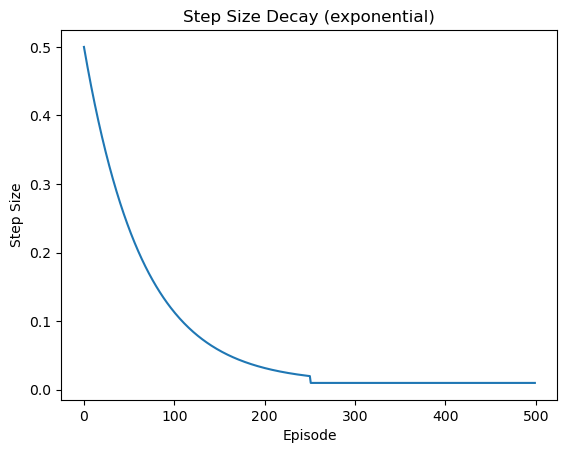

In [7]:
CONFIG = {
    "seed": 21, # following an internet meme
    'max_episodes': 500,
    'discount_factor': 0.99,
    'policy_name': 'go_left',
    'policy_action': 0,
    
    'step_size': {
        'initial_value': 0.5,
        'final_value': 0.01,
        'decay_type': 'exponential',
        'decay_stop': 250
    }
}

step_sizes = generate_episode_step_sizes(
    initial_value=CONFIG['step_size']['initial_value'],
    final_value=CONFIG['step_size']['final_value'],
    max_episode=CONFIG['max_episodes'],
    decay_type=CONFIG['step_size']['decay_type'],
    decay_stop=CONFIG['step_size']['decay_stop']
)
plot_step_size_decay(step_sizes, CONFIG['max_episodes'], CONFIG['step_size']['decay_type'])

#### Linear Decay

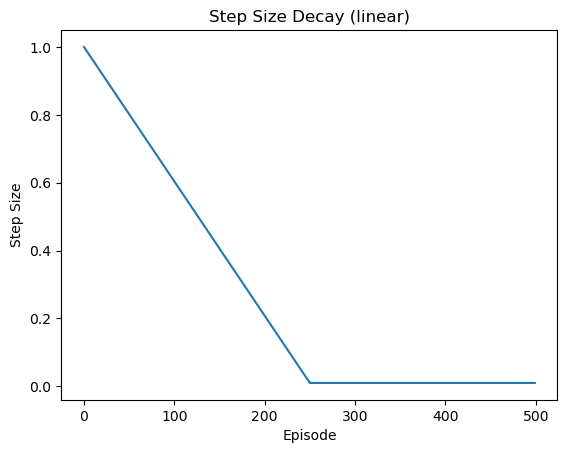

In [8]:
CONFIG = {
    "seed": 21, # following an internet meme
    'max_episodes': 500,
    'discount_factor': 0.99,
    'policy_name': 'go_left',
    'policy_action': 0,
    
    # 'step_size': {
    #     'initial_value': 1,
    #     'final_value': 0.001,
    #     'decay_type': 'exponential'
    # }
    'step_size': {
        'initial_value': 1,
        'final_value': 0.01,
        'decay_type': 'linear',
        'decay_stop': 250
    }
}

step_sizes = generate_episode_step_sizes(
    initial_value=CONFIG['step_size']['initial_value'],
    final_value=CONFIG['step_size']['final_value'],
    max_episode=CONFIG['max_episodes'],
    decay_type=CONFIG['step_size']['decay_type'],
    decay_stop=CONFIG['step_size']['decay_stop']
)
plot_step_size_decay(step_sizes, CONFIG['max_episodes'], CONFIG['step_size']['decay_type'])

## 3. Monte-Carlo Prediction

In [9]:
def monte_carlo_prediction(environment, config=None):
    assert config is not None
    max_episodes = config['max_episodes']
    V = np.zeros(environment.observation_space.n)
    V_r = np.zeros((max_episodes, environment.observation_space.n))
    visited = np.empty(environment.observation_space.n).fill(False)
    mc_target_tensor = np.zeros((max_episodes, environment.observation_space.n))
    
    for episode in trange(max_episodes, bar_format="{l_bar}{bar:20}{r_bar}", desc=f"Monte Carlo"):
        alpha = decay_step_size(config['step_size']['initial_value'], config['step_size']['final_value'], episode, max_episodes, config['step_size']['decay_type'])
        episode_trajectory = generate_episode_trajectory(environment, config)
        visited = np.array([False]*environment.observation_space.n)
        for i, (s, a, r, s_prime) in enumerate(episode_trajectory):
            if visited[s] and config['monte_carlo_strategy'] == 'first_visit': continue
            else:
                visited[s] = True
                discount_vector = config['discount_factor']**(np.arange(0, len(episode_trajectory)-i))
                reward_vector = np.array([r for _, _, r, _ in episode_trajectory[i:]])
                mc_target = np.dot(discount_vector, reward_vector)
                mc_target_tensor[episode, s] = mc_target
                V[s] += alpha*(mc_target - V[s])
        V_r[episode, :] = V
    if config['generate_episode_trajectory']:
        return V, V_r, episode_trajectory
    return V, V_r, mc_target_tensor

In [10]:
CONFIG = {
    "seed": 21, # following an internet meme
    'max_episodes': 1,
    'discount_factor': 0.99,
    'policy_name': 'go_left',
    'policy_action': 0,
    'max_steps': 20,
    'generate_episode_trajectory': True,
    
    'step_size': {
        'initial_value': 0.5,
        'final_value': 0.01,
        'decay_type': 'exponential',
        'decay_stop': 1
    },
    # 'step_size': {
    #     'initial_value': 1,
    #     'final_value': 0.01,
    #     'decay_type': 'linear'
    # },
    
    'monte_carlo_strategy': 'first_visit',
    # 'monte_carlo_strategy': 'every_visit',
}
V, V_r, episode_trajectory = monte_carlo_prediction(environment, CONFIG)
V, V_r, episode_trajectory

Monte Carlo: 100%|████████████████████| 1/1 [00:00<00:00, 122.79it/s]


(array([0., 0., 0., 0., 0., 0., 0.]),
 array([[0., 0., 0., 0., 0., 0., 0.]]),
 [(3, 0, 0.0, 2), (2, 0, 0.0, 1), (1, 0, 0.0, 0)])

## 4. Temporal Difference Learning

In [11]:
def td_prediction(environment, config=None):
    assert config is not None
    max_episodes = config['max_episodes']
    V = np.zeros(environment.observation_space.n)
    V_r = np.zeros((max_episodes, environment.observation_space.n))
    td_target_tensor = np.zeros((max_episodes, environment.observation_space.n))
    for episode in trange(max_episodes, bar_format="{l_bar}{bar:20}{r_bar}", desc=f"TD Prediction"):
        alpha = decay_step_size(config['step_size']['initial_value'], config['step_size']['final_value'], episode, max_episodes, config['step_size']['decay_type'])
        observation, info = environment.reset(seed=config['seed'])
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action = config['policy_action']
            observation_prime, reward, terminated, truncated, info = environment.step(action)
            td_target = reward
            if not (terminated or truncated):
                td_target += config['discount_factor'] * V[info["log"]["next_state"]]
            td_target_tensor[episode, info["log"]["current_state"]] = td_target
            V[info["log"]["current_state"]] += alpha*(td_target - V[info["log"]["current_state"]])
        V_r[episode, :] = V
    if config['generate_episode_trajectory']:
        return V, V_r, episode_trajectory
    return V, V_r, td_target_tensor

In [12]:
CONFIG = {
    "seed": 21, # following an internet meme
    'max_episodes': 1,
    'discount_factor': 0.99,
    'policy_name': 'go_left',
    'policy_action': 0,
    'generate_episode_trajectory': True,
    
    'step_size': {
        'initial_value': 0.1,
        'final_value': 0.1,
        'decay_type': 'exponential',
        'decay_stop': 1
    },
    # 'step_size': {
    #     'initial_value': 0.05,
    #     'final_value': 0.0001,
    #     'decay_type': 'linear'
    # },
    
    'monte_carlo_strategy': 'first_visit',
    # 'monte_carlo_strategy': 'every_visit',
}
environment = make('RandomWalk-v0', config=CONFIG, render_mode="rgb_array")
V, V_r, episode_trajectory = td_prediction(environment, CONFIG)
V, V_r, episode_trajectory

TD Prediction:   0%|                    | 0/1 [00:00<?, ?it/s]c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\s

(array([0. , 0. , 0. , 0. , 0. , 0.1, 0. ]),
 array([[0. , 0. , 0. , 0. , 0. , 0.1, 0. ]]),
 [(3, 0, 0.0, 2), (2, 0, 0.0, 1), (1, 0, 0.0, 0)])

# Plotting Values

In [13]:
def plot_episode_values(V_r, image_name, config=None):
    assert config is not None
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    for i, obs in enumerate(range(V_r.shape[1])[1:6]):
        ax[0].plot(range(config['max_episodes']), V_r[:, obs], label=f'V[{obs}]')
        ax[0].plot(range(config['max_episodes']), [(i+1)/6]*config['max_episodes'], linestyle='--', color='black')
    ax[0].set_title('Value of non-terminal states across all episodes')
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Value')
    
    for i, obs in enumerate(range(V_r.shape[1])[1:6]):
        ax[1].plot(range(config['max_episodes']), V_r[:, obs], label=f'V[{obs}]')
        ax[1].plot(range(config['max_episodes']), [(i+1)/6]*config['max_episodes'], linestyle='--', color='black')
    ax[1].set_title('Value of non-terminal states across all episodes in log scale')
    ax[1].set_xlabel('log(Episode)')
    ax[1].set_xscale('log')
    ax[1].set_ylabel('Value')
    plt.legend()
    plt.savefig(os.path.join(images_dir, image_name))

## 5, 9. Plotting for First Visit Monte-Carlo (FVMC) prediction

Monte Carlo: 100%|████████████████████| 500/500 [00:00<00:00, 11003.36it/s]


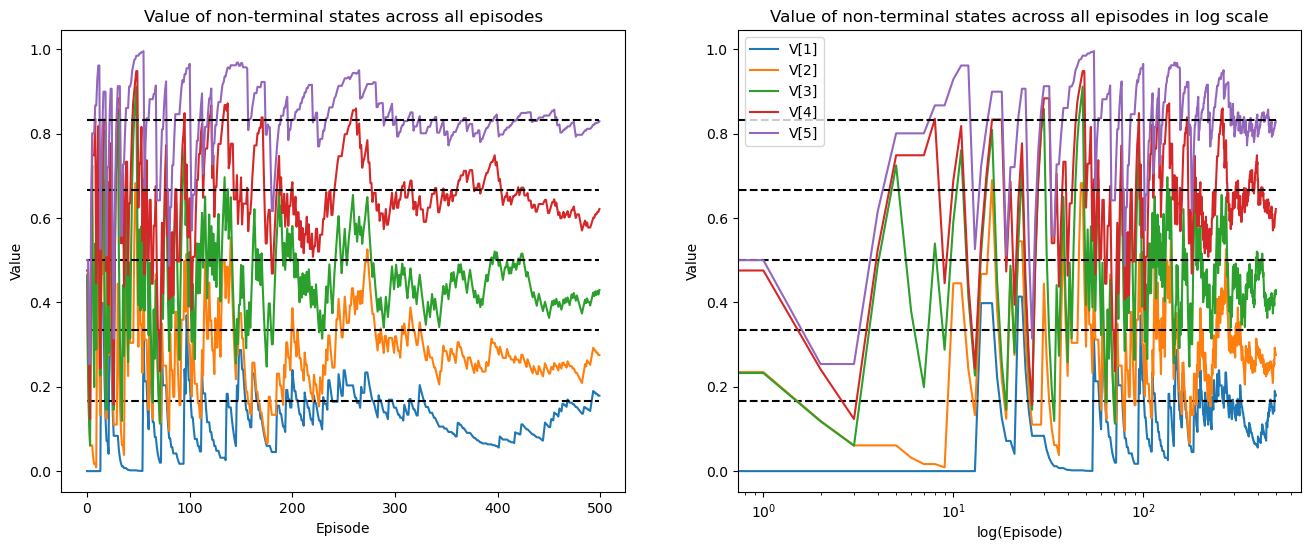

In [14]:
CONFIG = {
    "seed": 21, # following an internet meme
    'max_episodes': 500,
    'discount_factor': 0.99,
    'policy_name': 'go_left',
    'policy_action': 0,
    'max_steps': 30,
    'generate_episode_trajectory': False,
    
    'step_size': {
        'initial_value': 0.5,
        'final_value': 0.01,
        'decay_type': 'exponential',
        'decay_stop': 250
    },
    # 'step_size': {
    #     'initial_value': 1,
    #     'final_value': 0.01,
    #     'decay_type': 'linear'
    # },
    
    'monte_carlo_strategy': 'first_visit',
    # 'monte_carlo_strategy': 'every_visit',
}
environment = make('RandomWalk-v0', config=CONFIG, render_mode="rgb_array")
V, V_r, _ = monte_carlo_prediction(environment, CONFIG)
V.shape, V_r.shape
plot_episode_values(V_r, image_name=f"{CONFIG['monte_carlo_strategy']}_{CONFIG['step_size']['decay_type']}_{CONFIG['step_size']['initial_value']}_{CONFIG['step_size']['final_value']}_episode_values.pdf", config=CONFIG)

Tuned Hyperparameters

Monte Carlo:   0%|                    | 0/500 [00:00<?, ?it/s]c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\s

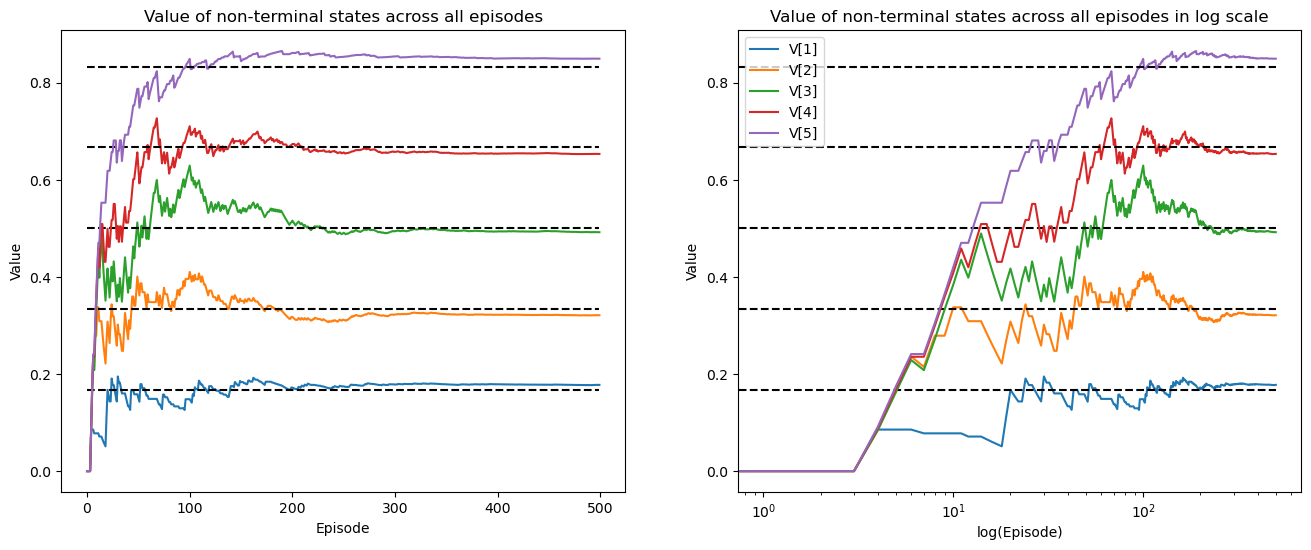

In [15]:
CONFIG = {
    "seed": 1, # following an internet meme
    'max_episodes': 500,
    'discount_factor': 0.99, # changed from 0.99
    'policy_name': 'go_left',
    'policy_action': 0,
    'max_steps': 31,
    'generate_episode_trajectory': False,
    
    'step_size': {
        'initial_value': 1e-1,
        'final_value': 1e-4,
        'decay_type': 'exponential',
        'decay_stop': 250
    },
    # 'step_size': {
    #     'initial_value': 1,
    #     'final_value': 0.01,
    #     'decay_type': 'linear'
    # },
    
    'monte_carlo_strategy': 'first_visit',
    # 'monte_carlo_strategy': 'every_visit',
}
environment = make('RandomWalk-v0', config=CONFIG, render_mode="rgb_array")
V, V_r, _ = monte_carlo_prediction(environment, CONFIG)
V.shape, V_r.shape
plot_episode_values(V_r, image_name=f"{CONFIG['monte_carlo_strategy']}_{CONFIG['step_size']['decay_type']}_{CONFIG['step_size']['initial_value']}_{CONFIG['step_size']['final_value']}_episode_values.pdf", config=CONFIG)

Monte Carlo:   0%|                    | 0/500 [00:00<?, ?it/s]c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\s

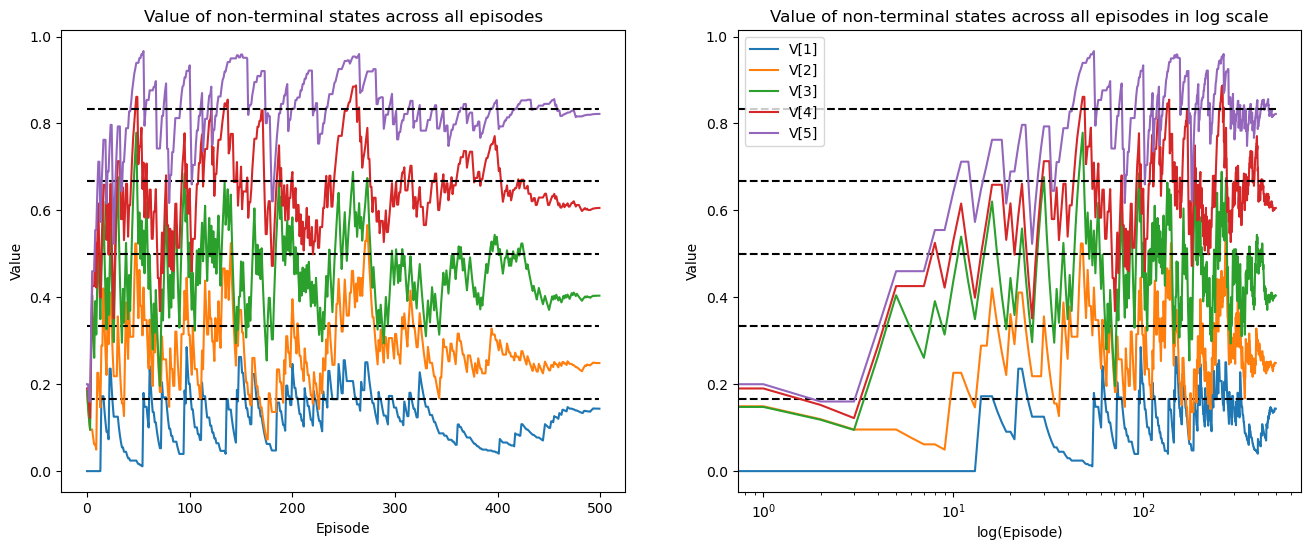

In [16]:
CONFIG = {
    "seed": 21, # following an internet meme
    'max_episodes': 500,
    'discount_factor': 0.99, # changed from 0.99
    'policy_name': 'go_left',
    'policy_action': 0,
    'max_steps': 30,
    'generate_episode_trajectory': False,
    
    # 'step_size': {
    #     'initial_value': 0.1,
    #     'final_value': 0.001,
    #     'decay_type': 'exponential',
    #     'decay_stop': 250
    # },
    'step_size': {
        'initial_value': 0.2,
        'final_value': 1e-12,
        'decay_type': 'linear',
        'decay_stop': 250
    },
    
    'monte_carlo_strategy': 'first_visit',
    # 'monte_carlo_strategy': 'every_visit',
}
environment = make('RandomWalk-v0', config=CONFIG, render_mode="rgb_array")
V, V_r, _ = monte_carlo_prediction(environment, CONFIG)
V.shape, V_r.shape
plot_episode_values(V_r, image_name=f"{CONFIG['monte_carlo_strategy']}_{CONFIG['step_size']['decay_type']}_{CONFIG['step_size']['initial_value']}_{CONFIG['step_size']['final_value']}_episode_values.pdf", config=CONFIG)

## 6, 10, 14. Plotting for Every Visit Monte-Carlo (EVMC) prediction

Monte Carlo:   0%|                    | 0/500 [00:00<?, ?it/s]c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\s

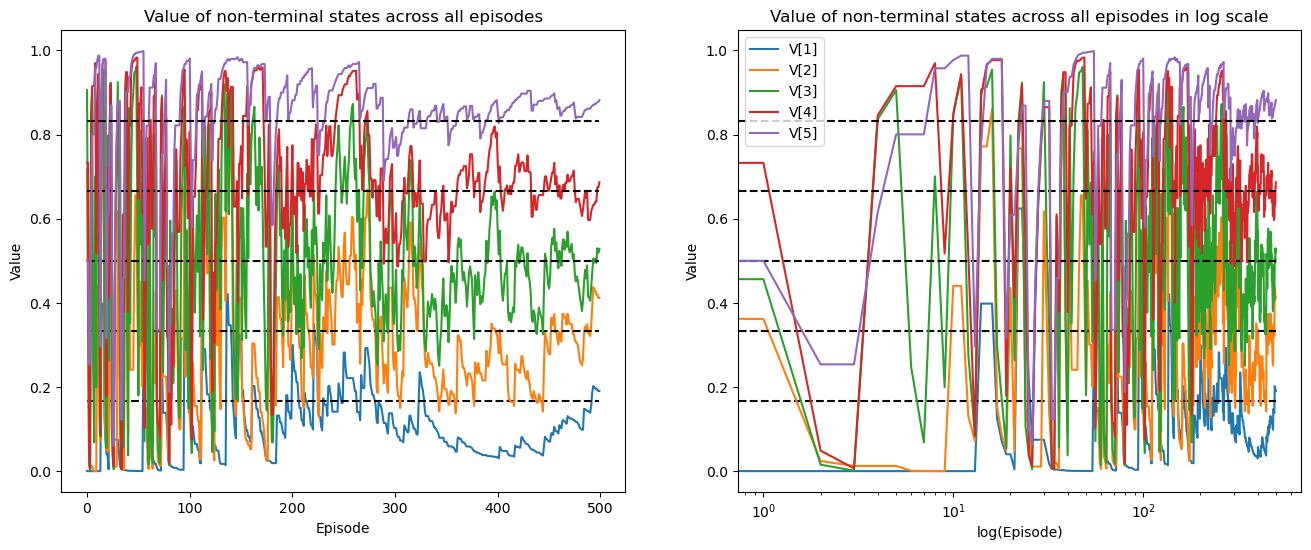

In [17]:
CONFIG = {
    "seed": 21, # following an internet meme
    'max_episodes': 500,
    'discount_factor': 0.99,
    'policy_name': 'go_left',
    'policy_action': 0,
    'max_steps': 30,
    'generate_episode_trajectory': False,
    
    'step_size': {
        'initial_value': 0.5,
        'final_value': 0.01,
        'decay_type': 'exponential',
        'decay_stop': 250
    },
    # 'step_size': {
    #     'initial_value': 1,
    #     'final_value': 0.01,
    #     'decay_type': 'linear'
    # },
    
    # 'monte_carlo_strategy': 'first_visit',
    'monte_carlo_strategy': 'every_visit',
}
environment = make('RandomWalk-v0', config=CONFIG, render_mode="rgb_array")
V, V_r, _ = monte_carlo_prediction(environment, CONFIG)
V.shape, V_r.shape
plot_episode_values(V_r, image_name=f"{CONFIG['monte_carlo_strategy']}_{CONFIG['step_size']['decay_type']}_{CONFIG['step_size']['initial_value']}_{CONFIG['step_size']['final_value']}_episode_values.pdf", config=CONFIG)

Tuned Hyperparameters

Monte Carlo:   0%|                    | 0/500 [00:00<?, ?it/s]c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\s

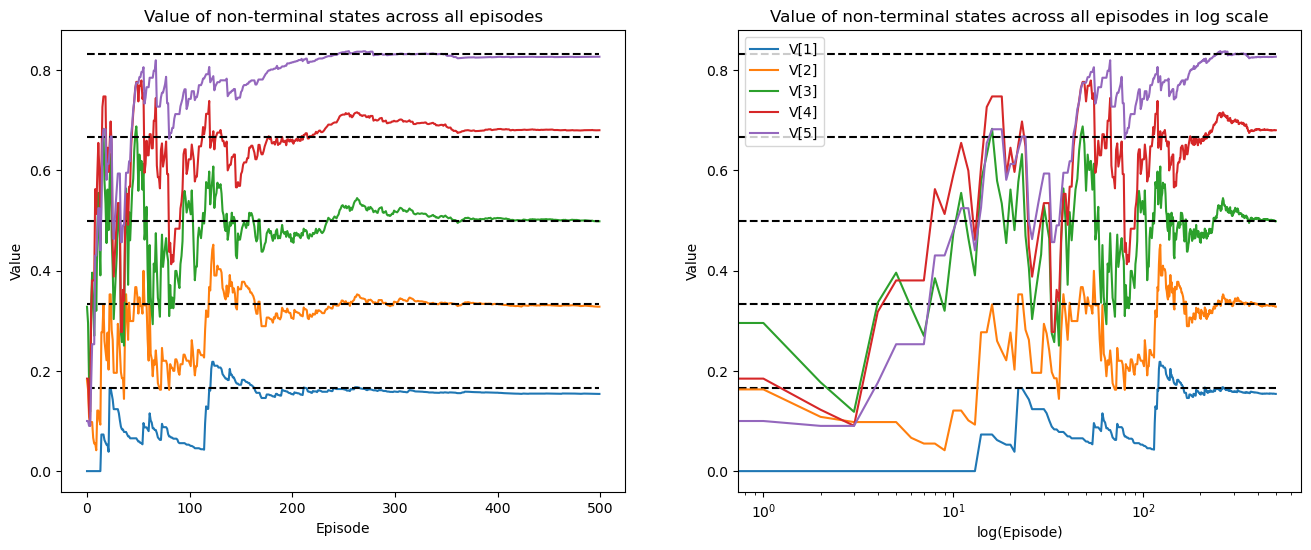

In [18]:
CONFIG = {
    "seed": 21, # following an internet meme
    'max_episodes': 500,
    'discount_factor': 0.99,
    'policy_name': 'go_left',
    'policy_action': 0,
    'max_steps': 31,
    'generate_episode_trajectory': False,
    
    'step_size': {
        'initial_value': 0.1,
        'final_value': 0.0001,
        'decay_type': 'exponential',
        'decay_stop': 250
    },
    # 'step_size': {
    #     'initial_value': 1,
    #     'final_value': 0.01,
    #     'decay_type': 'linear'
    # },
    
    # 'monte_carlo_strategy': 'first_visit',
    'monte_carlo_strategy': 'every_visit',
}
environment = make('RandomWalk-v0', config=CONFIG, render_mode="rgb_array")
V, V_r, _ = monte_carlo_prediction(environment, CONFIG)
V.shape, V_r.shape
plot_episode_values(V_r, image_name=f"{CONFIG['monte_carlo_strategy']}_{CONFIG['step_size']['decay_type']}_{CONFIG['step_size']['initial_value']}_{CONFIG['step_size']['final_value']}_episode_values.pdf", config=CONFIG)

## 7, 11, 15. TD Learning Plots

TD Prediction:   0%|                    | 0/500 [00:00<?, ?it/s]c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib

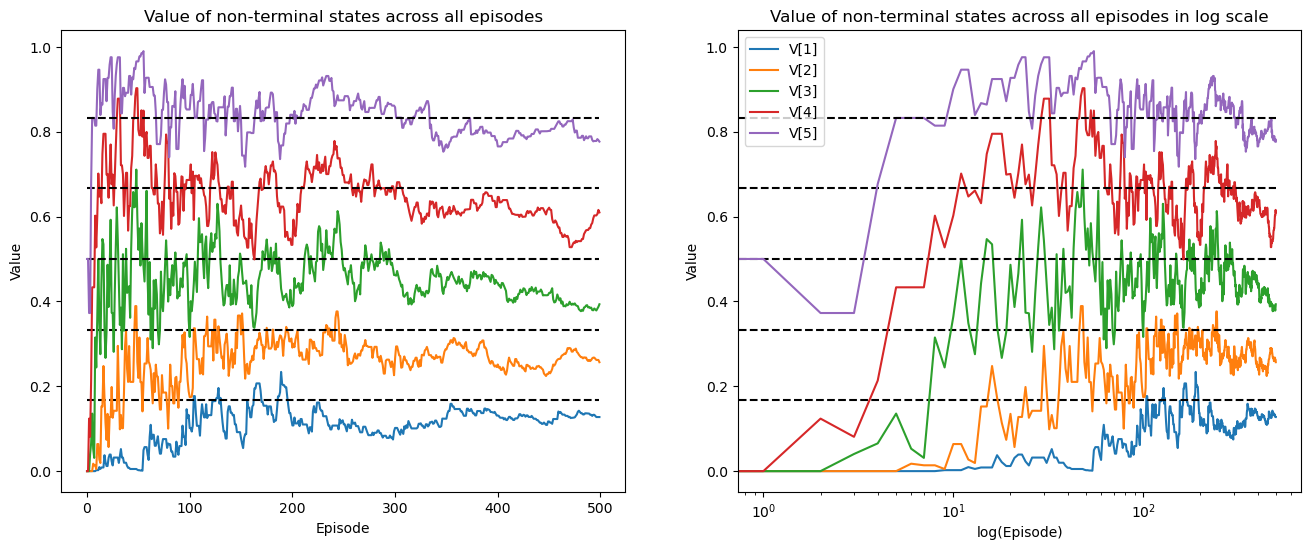

In [19]:
CONFIG = {
    "seed": 21, # following an internet meme
    'max_episodes': 500,
    'discount_factor': 0.99,
    'policy_name': 'go_left',
    'policy_action': 0,
    'max_steps': 31,
    'generate_episode_trajectory': False,
    
    'step_size': {
        'initial_value': 0.5,
        'final_value': 0.01,
        'decay_type': 'exponential',
        'decay_stop': 250
    },
    # 'step_size': {
    #     'initial_value': 0.05,
    #     'final_value': 0.0001,
    #     'decay_type': 'linear'
    # },
    
    'monte_carlo_strategy': 'first_visit',
    # 'monte_carlo_strategy': 'every_visit',
}
environment = make('RandomWalk-v0', config=CONFIG, render_mode="rgb_array")
V, V_r, _ = td_prediction(environment, CONFIG)
plot_episode_values(V_r, image_name=f"td_learning_{CONFIG['step_size']['decay_type']}_{CONFIG['step_size']['initial_value']}_{CONFIG['step_size']['final_value']}_episode_values.pdf", config=CONFIG)

Hyperparameter tuned

TD Prediction:   0%|                    | 0/500 [00:00<?, ?it/s]c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib

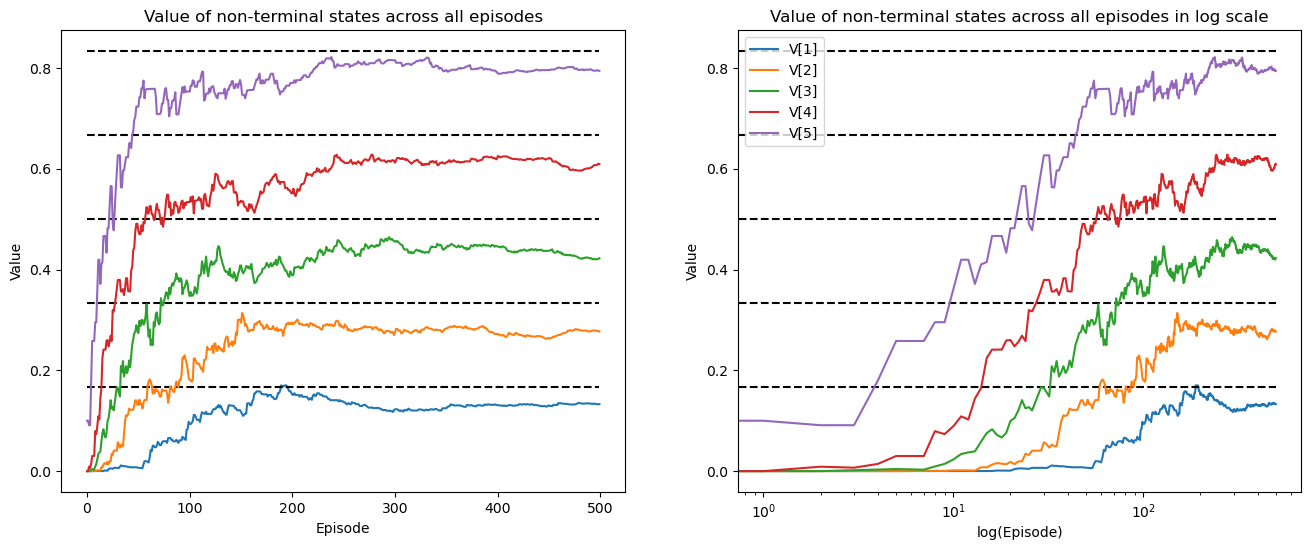

In [20]:
CONFIG = {
    "seed": 21, # following an internet meme
    'max_episodes': 500,
    'discount_factor': 0.99,
    'policy_name': 'go_left',
    'policy_action': 0,
    'max_steps': 31,
    'generate_episode_trajectory': False,
    
    'step_size': {
        'initial_value': 0.1,
        'final_value': 0.002,
        'decay_type': 'exponential',
        'decay_stop': 250
    },
    # 'step_size': {
    #     'initial_value': 0.05,
    #     'final_value': 0.0001,
    #     'decay_type': 'linear'
    # },
    
    'monte_carlo_strategy': 'first_visit',
    # 'monte_carlo_strategy': 'every_visit',
}
environment = make('RandomWalk-v0', config=CONFIG, render_mode="rgb_array")
V, V_r, _ = td_prediction(environment, CONFIG)
plot_episode_values(V_r, image_name=f"td_learning_{CONFIG['step_size']['decay_type']}_{CONFIG['step_size']['initial_value']}_{CONFIG['step_size']['final_value']}_episode_values.pdf", config=CONFIG)

## 8. Run tests on all strategies to smoothen curves

In [21]:
def run_experiments(environment, max_runs=50, fvmc_config=None, evmc_config=None, td_config=None):
    FVMC_V = np.zeros((max_runs, environment.observation_space.n))
    FVMC_V_r = np.zeros((max_runs, fvmc_config['max_episodes'], environment.observation_space.n))
    
    EVMC_V = np.zeros((max_runs, environment.observation_space.n))
    EVMC_V_r = np.zeros((max_runs, evmc_config['max_episodes'], environment.observation_space.n))
    
    TD_V = np.zeros((max_runs, environment.observation_space.n))
    TD_V_r = np.zeros((max_runs, td_config['max_episodes'], environment.observation_space.n))
    
    for run in trange(max_runs):
        V, V_r, _ = monte_carlo_prediction(environment, fvmc_config)
        FVMC_V[run, :] = V
        FVMC_V_r[run, :, :] = V_r
        V, V_r, _ = monte_carlo_prediction(environment, evmc_config)
        EVMC_V[run, :] = V
        EVMC_V_r[run, :, :] = V_r
        
        V, V_r, _ = td_prediction(environment, td_config)
        TD_V[run, :] = V
        TD_V_r[run, :, :] = V_r
    
    FVMC_V_r = np.mean(FVMC_V_r, axis=0)
    EVMC_V_r = np.mean(EVMC_V_r, axis=0)
    TD_V_r = np.mean(TD_V_r, axis=0)
    
    plot_episode_values(FVMC_V_r, image_name=f"fvmc_experiments_{max_runs}.pdf", config=fvmc_config)
    plot_episode_values(EVMC_V_r, image_name=f"evmc_experiments_{max_runs}.pdf", config=evmc_config)
    plot_episode_values(TD_V_r, image_name=f"td_experiments_{max_runs}.pdf", config=td_config)
    
    return FVMC_V, FVMC_V_r, EVMC_V, EVMC_V_r, TD_V, TD_V_r


100%|██████████| 50/50 [00:06<00:00,  7.91it/s]


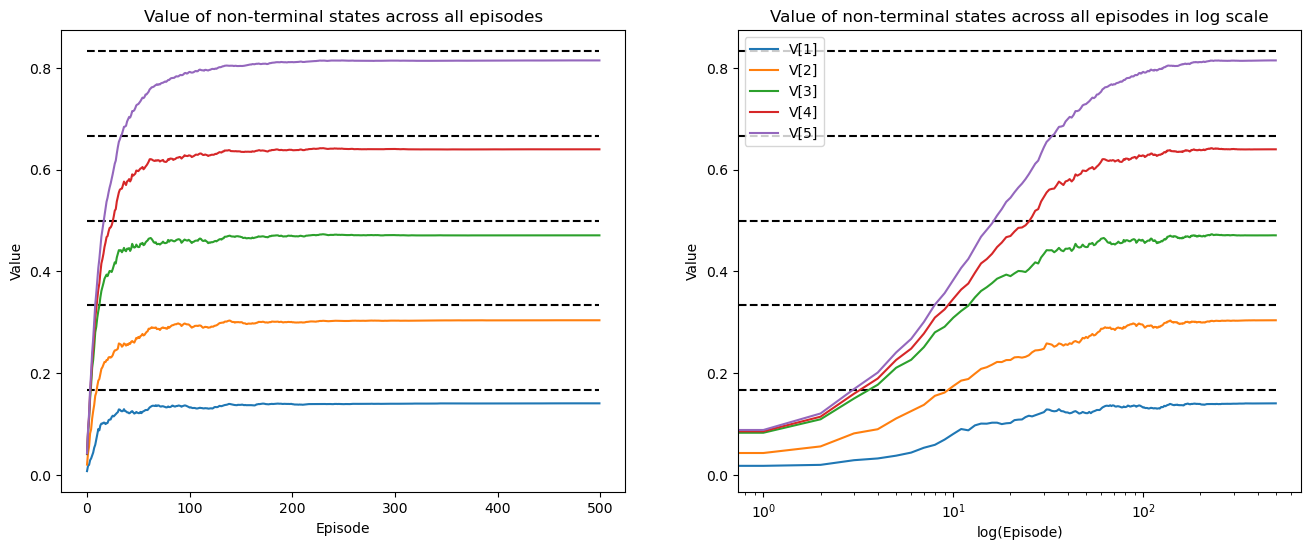

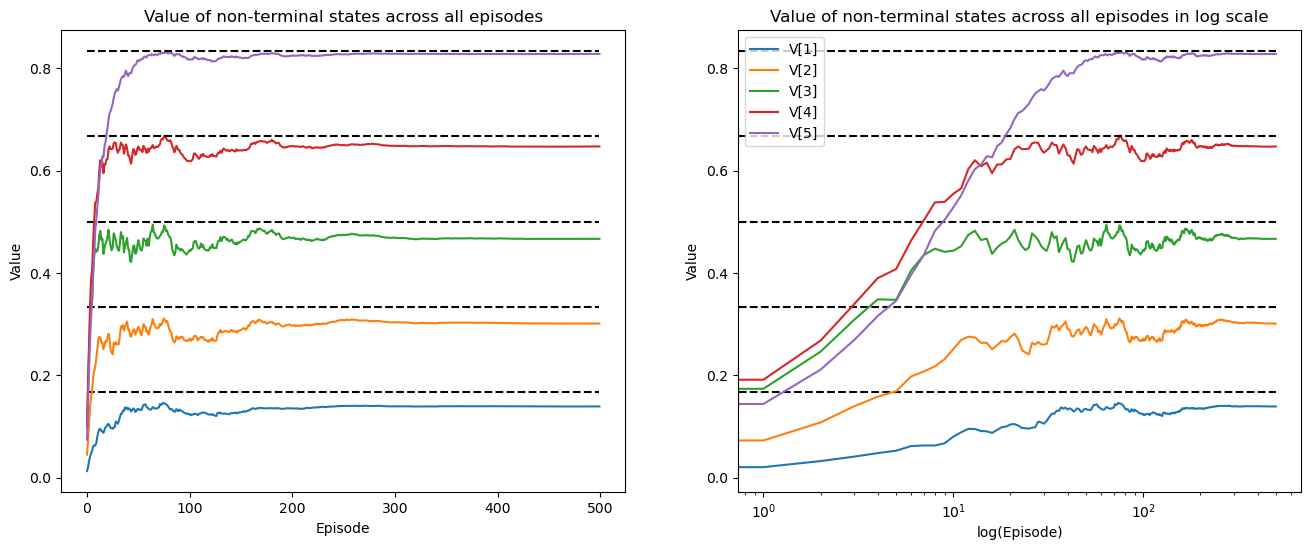

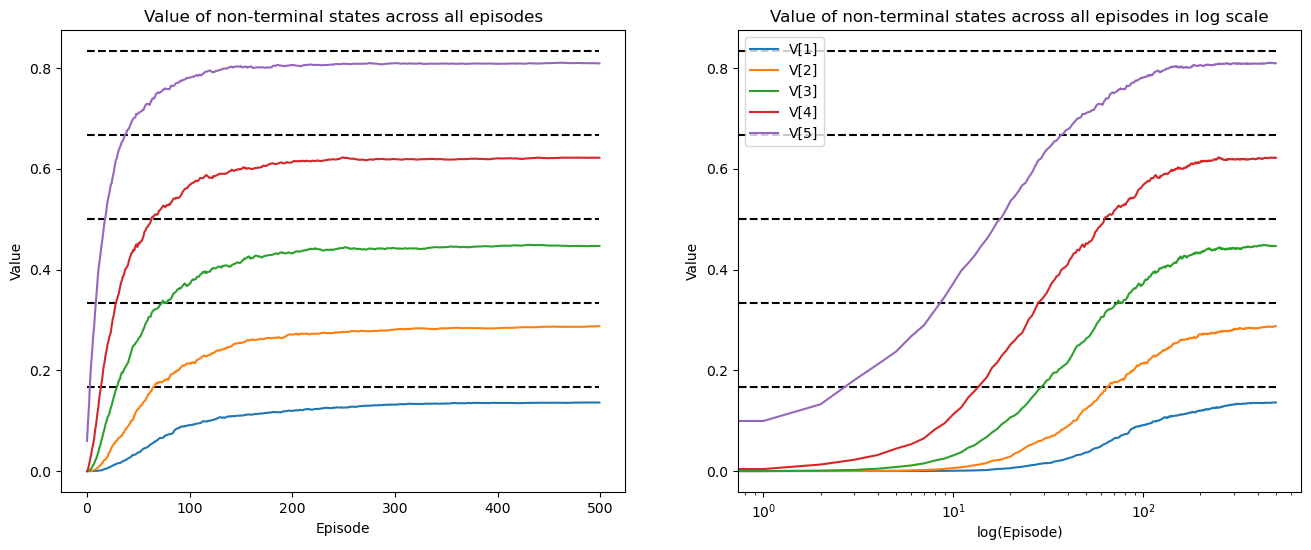

In [22]:
FVMC_CONFIG = {
    "seed": 1, # following an internet meme
    'max_episodes': 500,
    'discount_factor': 0.99, # changed from 0.99
    'policy_name': 'go_left',
    'policy_action': 0,
    'max_steps': 31,
    'generate_episode_trajectory': False,
    
    'step_size': {
        'initial_value': 1e-1,
        'final_value': 1e-4,
        'decay_type': 'exponential',
        'decay_stop': 250
    },
    
    'monte_carlo_strategy': 'first_visit',
}

EVMC_CONFIG = {
    "seed": 21, # following an internet meme
    'max_episodes': 500,
    'discount_factor': 0.99,
    'policy_name': 'go_left',
    'policy_action': 0,
    'max_steps': 31,
    'generate_episode_trajectory': False,
    
    'step_size': {
        'initial_value': 0.1,
        'final_value': 0.0001,
        'decay_type': 'exponential',
        'decay_stop': 250
    },
    'monte_carlo_strategy': 'every_visit',
}

TD_CONFIG = {
    "seed": 21, # following an internet meme
    'max_episodes': 500,
    'discount_factor': 0.99,
    'policy_name': 'go_left',
    'policy_action': 0,
    'max_steps': 31,
    'generate_episode_trajectory': False,
    
    'step_size': {
        'initial_value': 0.1,
        'final_value': 0.002,
        'decay_type': 'exponential',
        'decay_stop': 250
    }
}

experiment_results = run_experiments(environment, max_runs=50, fvmc_config=FVMC_CONFIG, evmc_config=EVMC_CONFIG, td_config=TD_CONFIG)

# Plotting target values of a non-terminal state

In [23]:
def plot_target_values(target_tensor, state_id, title=None, image_name=None, config=None):
    assert config is not None
    fig = plt.figure(figsize=(8, 6))
    plt.plot(range(config['max_episodes']), target_tensor[:, state_id], 'o', label=f'V[{state_id}]', alpha=0.5)
    plt.axhline(y=(state_id)/6, color='black', linestyle='--', label='True Value')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.legend()
    plt.savefig(os.path.join(images_dir, image_name))


## 13. FVMC - Plotting $G_t$ for state 3

Monte Carlo:   0%|                    | 0/500 [00:00<?, ?it/s]c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\s

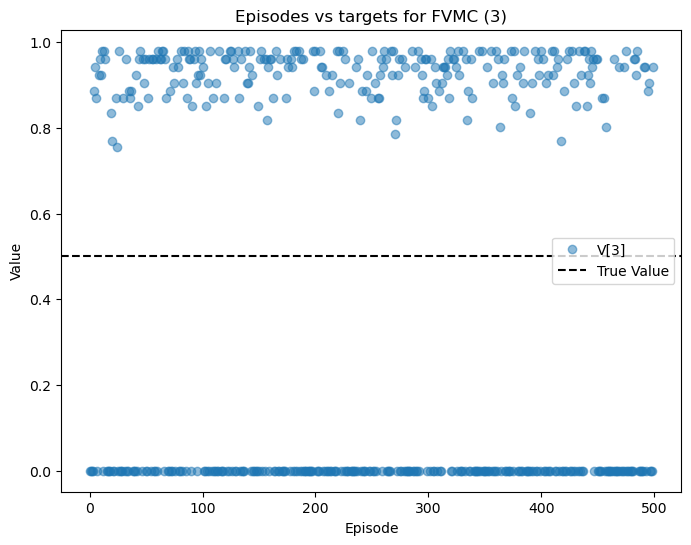

In [24]:
CONFIG = {
    "seed": 1, # following an internet meme
    'max_episodes': 500,
    'discount_factor': 0.99, # changed from 0.99
    'policy_name': 'go_left',
    'policy_action': 0,
    'max_steps': 31,
    'generate_episode_trajectory': False,
    'state_id': 3,
    
    'step_size': {
        'initial_value': 0.5,
        'final_value': 0.001,
        'decay_type': 'exponential',
        'decay_stop': 250
    },
    # 'step_size': {
    #     'initial_value': 1,
    #     'final_value': 0.01,
    #     'decay_type': 'linear'
    # },
    
    'monte_carlo_strategy': 'first_visit',
    # 'monte_carlo_strategy': 'every_visit',
}
environment = make('RandomWalk-v0', config=CONFIG, render_mode="rgb_array")
V, V_r, target_tensor = monte_carlo_prediction(environment, CONFIG)
plot_target_values(target_tensor, state_id=CONFIG['state_id'], title=f'Episodes vs targets for FVMC ({CONFIG["state_id"]})', image_name=f"{CONFIG['monte_carlo_strategy']}_{CONFIG['step_size']['decay_type']}_{CONFIG['step_size']['initial_value']}_{CONFIG['step_size']['final_value']}_episode_vs_targets.pdf", config=CONFIG)

Monte Carlo:   0%|                    | 0/500 [00:00<?, ?it/s]c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\s

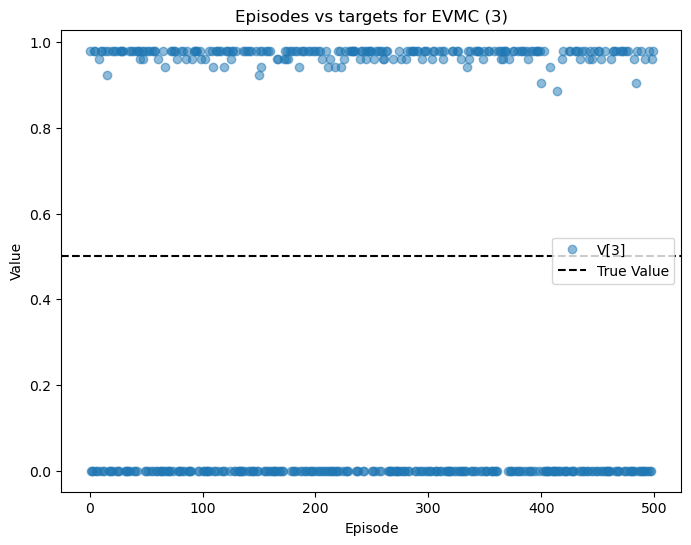

In [25]:
CONFIG = {
    "seed": 21, # following an internet meme
    'max_episodes': 500,
    'discount_factor': 0.99,
    'policy_name': 'go_left',
    'policy_action': 0,
    'max_steps': 31,
    'generate_episode_trajectory': False,
    'state_id': 3,
    
    'step_size': {
        'initial_value': 0.5,
        'final_value': 0.001,
        'decay_type': 'exponential',
        'decay_stop': 250
    },
    'monte_carlo_strategy': 'every_visit',
}
environment = make('RandomWalk-v0', config=CONFIG, render_mode="rgb_array")
V, V_r, target_tensor = monte_carlo_prediction(environment, CONFIG)
plot_target_values(target_tensor, state_id=CONFIG['state_id'], 
                   title=f'Episodes vs targets for EVMC ({CONFIG["state_id"]})', 
                   image_name=f"{CONFIG['monte_carlo_strategy']}_{CONFIG['step_size']['decay_type']}_{CONFIG['step_size']['initial_value']}_{CONFIG['step_size']['final_value']}_episode_vs_targets.pdf", 
                   config=CONFIG)

TD Prediction:   0%|                    | 0/500 [00:00<?, ?it/s]c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib

TD Prediction: 100%|████████████████████| 500/500 [00:00<00:00, 12162.06it/s]


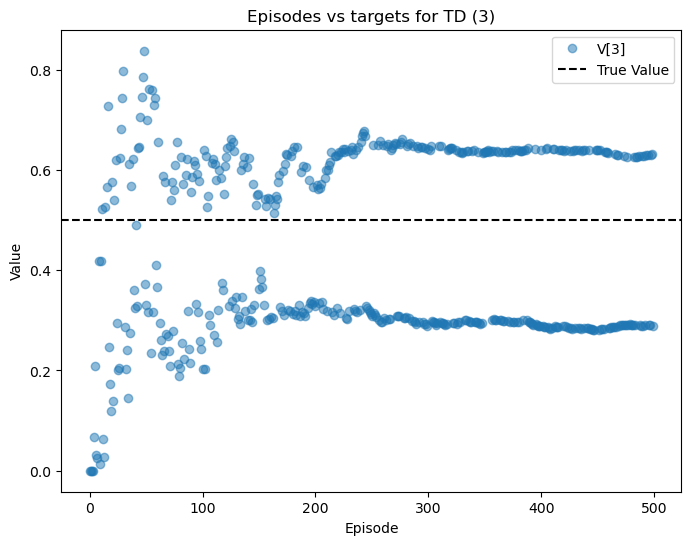

In [26]:
CONFIG = {
    "seed": 21, # following an internet meme
    'max_episodes': 500,
    'discount_factor': 0.99,
    'policy_name': 'go_left',
    'policy_action': 0,
    'max_steps': 31,
    'generate_episode_trajectory': False,
    'state_id': 3,
    
    'step_size': {
        'initial_value': 0.5,
        'final_value': 0.001,
        'decay_type': 'exponential',
        'decay_stop': 250
    }
}
environment = make('RandomWalk-v0', config=CONFIG, render_mode="rgb_array")
V, V_r, target_tensor = td_prediction(environment, CONFIG)
plot_target_values(target_tensor, state_id=CONFIG['state_id'], title=f'Episodes vs targets for TD ({CONFIG["state_id"]})', image_name=f"td_learning_{CONFIG['step_size']['decay_type']}_{CONFIG['step_size']['initial_value']}_{CONFIG['step_size']['final_value']}_episode_vs_targets.pdf", config=CONFIG)